In [32]:
# !pip install pykrige

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import geopandas as gpd
from shapely.geometry import Point
from pykrige.ok import OrdinaryKriging

import sys
sys.path.insert(0, './')
from functions import *

## Import Cleaned Data

In [107]:
acs = pd.read_parquet("Data/Cleaned/ACS.parquet")
citi =  pd.read_parquet("Data/Cleaned/Citibike_Clean/citibike_all_processed.parquet")

In [108]:
# merge df's together on hard tract name (with decimal points)

df = acs.merge(citi, left_on=['full_tract','year'], right_on=['Tract','Year'], how='left')
df.drop(['Tract','Year'],axis=1,inplace=True)
# df['Proportion_citibike_rides'] = df['Proportion_citibike_rides'].fillna(0)  #### TODO: spatial interpolation?



In [109]:
## Add Tree Census

tree = pd.read_parquet("Data/Cleaned/tree_census.parquet")
tree['year'] = tree['year'].astype(str)
df = df.merge(tree, on=['full_tract', 'year'], how='left')
# df['num_trees'] = df['num_trees'].fillna(0)  #### TODO: spatial interpolation?


In [110]:
## Zillow Data

zillow = pd.read_parquet("Data/Cleaned/zillow_clean.parquet")
df = df.merge(zillow, on=['full_tract','year'], how='left')
# df.med_rent.fillna(2000, inplace=True)  ###### TODO fillna spatial interpolation


## Outliers

In [111]:
# replace all outliers with nan

# columns with very large positive outliers
df['med_hh_tenure'] = np.where(df['med_hh_tenure']>666668689, np.nan, df['med_hh_tenure'])
df['med_income'] = df['med_income'].astype(float)

# columns with very large negative outliers
for col in ['percent_work_agriculture','percent_work_construction', 'percent_work_retail', 'percent_work_finance', 'percent_work_stem', 'percent_work_edu_health',
 'percent_work_art','med_income', 'med_rent_acs', 'med_age', 'med_value', 'med_hh_age']:
    df[col] = np.where(df[col]<0, np.nan, df[col])


# change house age of 2024 to zero
df.loc[df['med_hh_age']>1000, 'med_hh_age'] = 2024-df.loc[df['med_hh_age']>1000, 'med_hh_age']


# # replace missing values with the mean of that year. TODO: interpolate missing vals with padded years

# for yr in df.year.unique():
#     for col in ['med_value','med_hh_age','med_income','med_hh_tenure']:
#         mean = df[df.year==yr][col].mean()
#         df.loc[df.year==yr, col] = df.loc[df.year==yr, col].replace(to_replace= -999, value=mean)
        

## Kriging Spatial Interpolation
needs to happen for each column & year individually

In [113]:
# retrieve spatial coordinates for each county

# Load the census tract shapefile
nyc_tracts = gpd.read_file('Data/Raw/tracts2020_shapefile/nyct2020.shp')

def get_random_point_within(geometry):
    minx, miny, maxx, maxy = geometry.bounds
    while True:
        random_point = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if geometry.contains(random_point):
            return random_point

# Generate a random coordinate for each census tract
nyc_tracts["random_point"] = nyc_tracts["geometry"].apply(get_random_point_within)

# Extract coordinates
nyc_tracts["random_lat"] = nyc_tracts["random_point"].apply(lambda p: p.y)
nyc_tracts["random_lon"] = nyc_tracts["random_point"].apply(lambda p: p.x)

df = df.merge(nyc_tracts[["GEOID", "random_lat", "random_lon"]], on='GEOID')


In [170]:
cols_to_interpolate = df.columns.drop(['NAME','full_tract', 'GEOID','year',"random_lat", "random_lon"])
timeframe = df.year.unique()
all_estimates = {}

for yr in timeframe:
    df_yr = df[df.year==yr]
    all_estimates[yr] = {}
    print(yr)
    
    for col in cols_to_interpolate:  # loop through each column
        if col in ['Proportion_citibike_rides'] and yr in ['2010','2011','2012','2023']:
            continue
        if col in ['num_trees','med_rent'] and yr in ['2023']:  ## TODO: go back and retrieve tree data for 2023
            continue
            
        # separate the df into the rows we use to train kriging, and the rows with unknown values TODO: exclude rows we want to use temporal interpolation instead
        df_estimates = df_yr[df_yr[col].isnull()][['GEOID','random_lat','random_lon']]
        df_known = df_yr.drop(df_estimates.index)[['random_lat','random_lon',col]]
        # df_known = df_known[['random_lat','random_lon',col]]
    
        ## Convert to NumPy arrays:
        # rows we train kriging on
        lat, lon, vals = df_known["random_lat"].values, df_known["random_lon"].values, df_known[col].values
        # rows with unknown values
        interp_lat = df_estimates["random_lat"].values
        interp_lon = df_estimates["random_lon"].values
    
        # Perform Ordinary Kriging with 'points' execution
        OK = OrdinaryKriging(
            lon, lat, vals,  
            variogram_model="spherical",
            verbose=False,
            enable_plotting=False
        )
        vals_interpolated, sigma = OK.execute("points", interp_lon, interp_lat)
        df_estimates["estimated_"+col] = vals_interpolated
        all_estimates[yr][col] = df_estimates
        

In [169]:
# add the estimated Kriging data back into the main dataset
all_yrs_interpolated = []

for yr in timeframe:
    df_yr = df[df.year==yr]
    
    for col in cols_to_interpolate:  # loop through each column
        if col in ['Proportion_citibike_rides'] and yr in ['2010','2011','2012','2023']:
            continue
        if col in ['num_trees','med_rent'] and yr in ['2023']:  ## TODO: go back and retrieve tree data for 2023
            continue
            
        df_yr = df_yr.merge(all_estimates[yr][col].drop(['random_lat','random_lon'], axis=1), on='GEOID', how='left')
        df_yr[col] = df_yr[col].fillna(df_yr['estimated_'+col])
        df_yr.drop(['estimated_'+col], axis=1, inplace=True)
    all_yrs_interpolated.append(df_yr)
df = pd.concat(all_yrs_interpolated)

### Temporal Interpolation

In [77]:
# TODO sort dataframe on tracts and years, then backfill missing vals
sorted = df.sort_values(['full_tract','year']).reset_index(drop=True)
df = sorted.groupby('full_tract').bfill().reset_index(drop=True)


,NAME,total_pop,percent_hh_income_assist,percent_hh_snap,percent_hh_english,percent_out_of_county,percent_moved_within_county,percent_public_transit,percent_drive_commute,percent_bike_commute,...,med_value,percent_hh_electric,percent_hh_solar,year,med_hh_age,med_hh_tenure,GEOID,Proportion_citibike_rides,num_trees,med_rent
0,"Census Tract 1, Bronx County, New York",11517.0,NaN,NaN,NaN,0.583138,0.191282,0.0,0.0,0.0,...,-666666666.0,NaN,NaN,2010,-666664641.0,666668691.0,36005000100,0.0,0.0,2446.190968
1,"Census Tract 1, Bronx County, New York",10453.0,NaN,NaN,NaN,0.604420,0.207022,0.0,0.0,0.0,...,-666666666.0,NaN,NaN,2011,-666664641.0,666668691.0,36005000100,0.0,0.0,2446.190968
2,"Census Tract 1, Bronx County, New York",9741.0,NaN,NaN,NaN,0.587414,0.211991,0.0,0.0,0.0,...,-666666666.0,NaN,NaN,2012,-666664641.0,666668691.0,36005000100,0.0,0.0,2446.190968
3,"Census Tract 1, Bronx County, New York",9191.0,NaN,NaN,NaN,0.552932,0.219780,0.0,0.0,0.0,...,-666666666.0,NaN,NaN,2013,-666664641.0,666668691.0,36005000100,0.0,0.0,2446.190968
4,"Census Tract 1, Bronx County, New York",8430.0,NaN,NaN,NaN,0.543298,0.219692,0.0,0.0,0.0,...,-666666666.0,NaN,NaN,2014,-666664641.0,666668691.0,36005000100,0.0,0.0,2446.190968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34421,"Census Tract 9901, Richmond County, New York",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-666666666.0,NaN,NaN,2019,-666664641.0,666668691.0,36085990100,0.0,0.0,2000.000000
34422,"Census Tract 9901, Richmond County, New York",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-666666666.0,NaN,NaN,2020,-666664641.0,666668691.0,36085990100,0.0,0.0,2000.000000
34423,"Census Tract 9901, Richmond County, New York",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-666666666.0,NaN,NaN,2021,-666664641.0,666668691.0,36085990100,0.0,0.0,2000.000000
34424,Census Tract 9901; Richmond County; New York,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-666666666.0,NaN,NaN,2022,-666664641.0,666668691.0,36085990100,0.0,0.0,2000.000000


## Normalize

In [8]:
# # normalize certain columns

# for yr in df.year.unique():
#     yr_df = df[df.year == yr]
#     for col in ['med_income','med_value','med_hh_age','med_hh_residence','num_trees']:
#         yr_df[col] = yr_df[col].astype(float)
#         yr_df[col] = (yr_df[col] - yr_df[col].min()) / (yr_df[col].max() - yr_df[col].min())
#     dropped = df.drop(df.iloc[yr_df.index].index)  # drop that year from main df
#     df = pd.concat([dropped, yr_df]).reset_index(drop=True)  # add that year back
# df.sort_values(['full_tract','year'], inplace=True)

In [46]:
# df.to_pickle('Data/Cleaned/postprocessed.pkl')


In [108]:
# df[df.full_tract=='047042300'] # my bushwick neighborhood
# df[df.full_tract=='047026500'] # my bedstuy neighborhood

In [21]:
# we have 2016 labels, we need 2022 labels
# X is 2016 features, y is 2016 label
# predict on 2022 features, spits out preds for 2022 labels

In [30]:
# define feature set and split data

feat = ['percent_white', 'percent_black', 'percent_native',
       'percent_asian', 'percent_pacific', 'percent_latino',
       'percent_bachelors', 'percent_grad', 'percent_instate', 'med_income',
       'percent_owned', 'percent_rented', 'med_value', 'year', 'med_hh_age',
       'med_hh_residence', 'Proportion_citibike_rides',
       'num_trees', 'med_rent']

# define variables
y = udp_df['eligible']
X = udp_df[feat]



In [31]:
logreg = LogisticRegression()
kf = KFold(n_splits=5, shuffle=True)
logreg.fit(X,y)
cv_scores = cross_val_score(logreg, X, y, cv=kf, scoring="accuracy")
print("CV Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

CV Scores: [0.91065292 0.91034483 0.91724138 0.86206897 0.89310345]
Mean Accuracy: 0.8986823083303708


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [25]:
# use model trained on 2016 data to predict 2022 labels
df_22 = df[df.year=='2022']
X_22 = df_22[feat]

labels_22 = logreg.predict(X_22)
df_22['pred_eligible']=labels_22


/var/folders/w0/4r14_1sj0j7fl6nz7v1nwgkr0000gp/T/ipykernel_67089/3550495221.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_22['pred_eligible']=labels_22


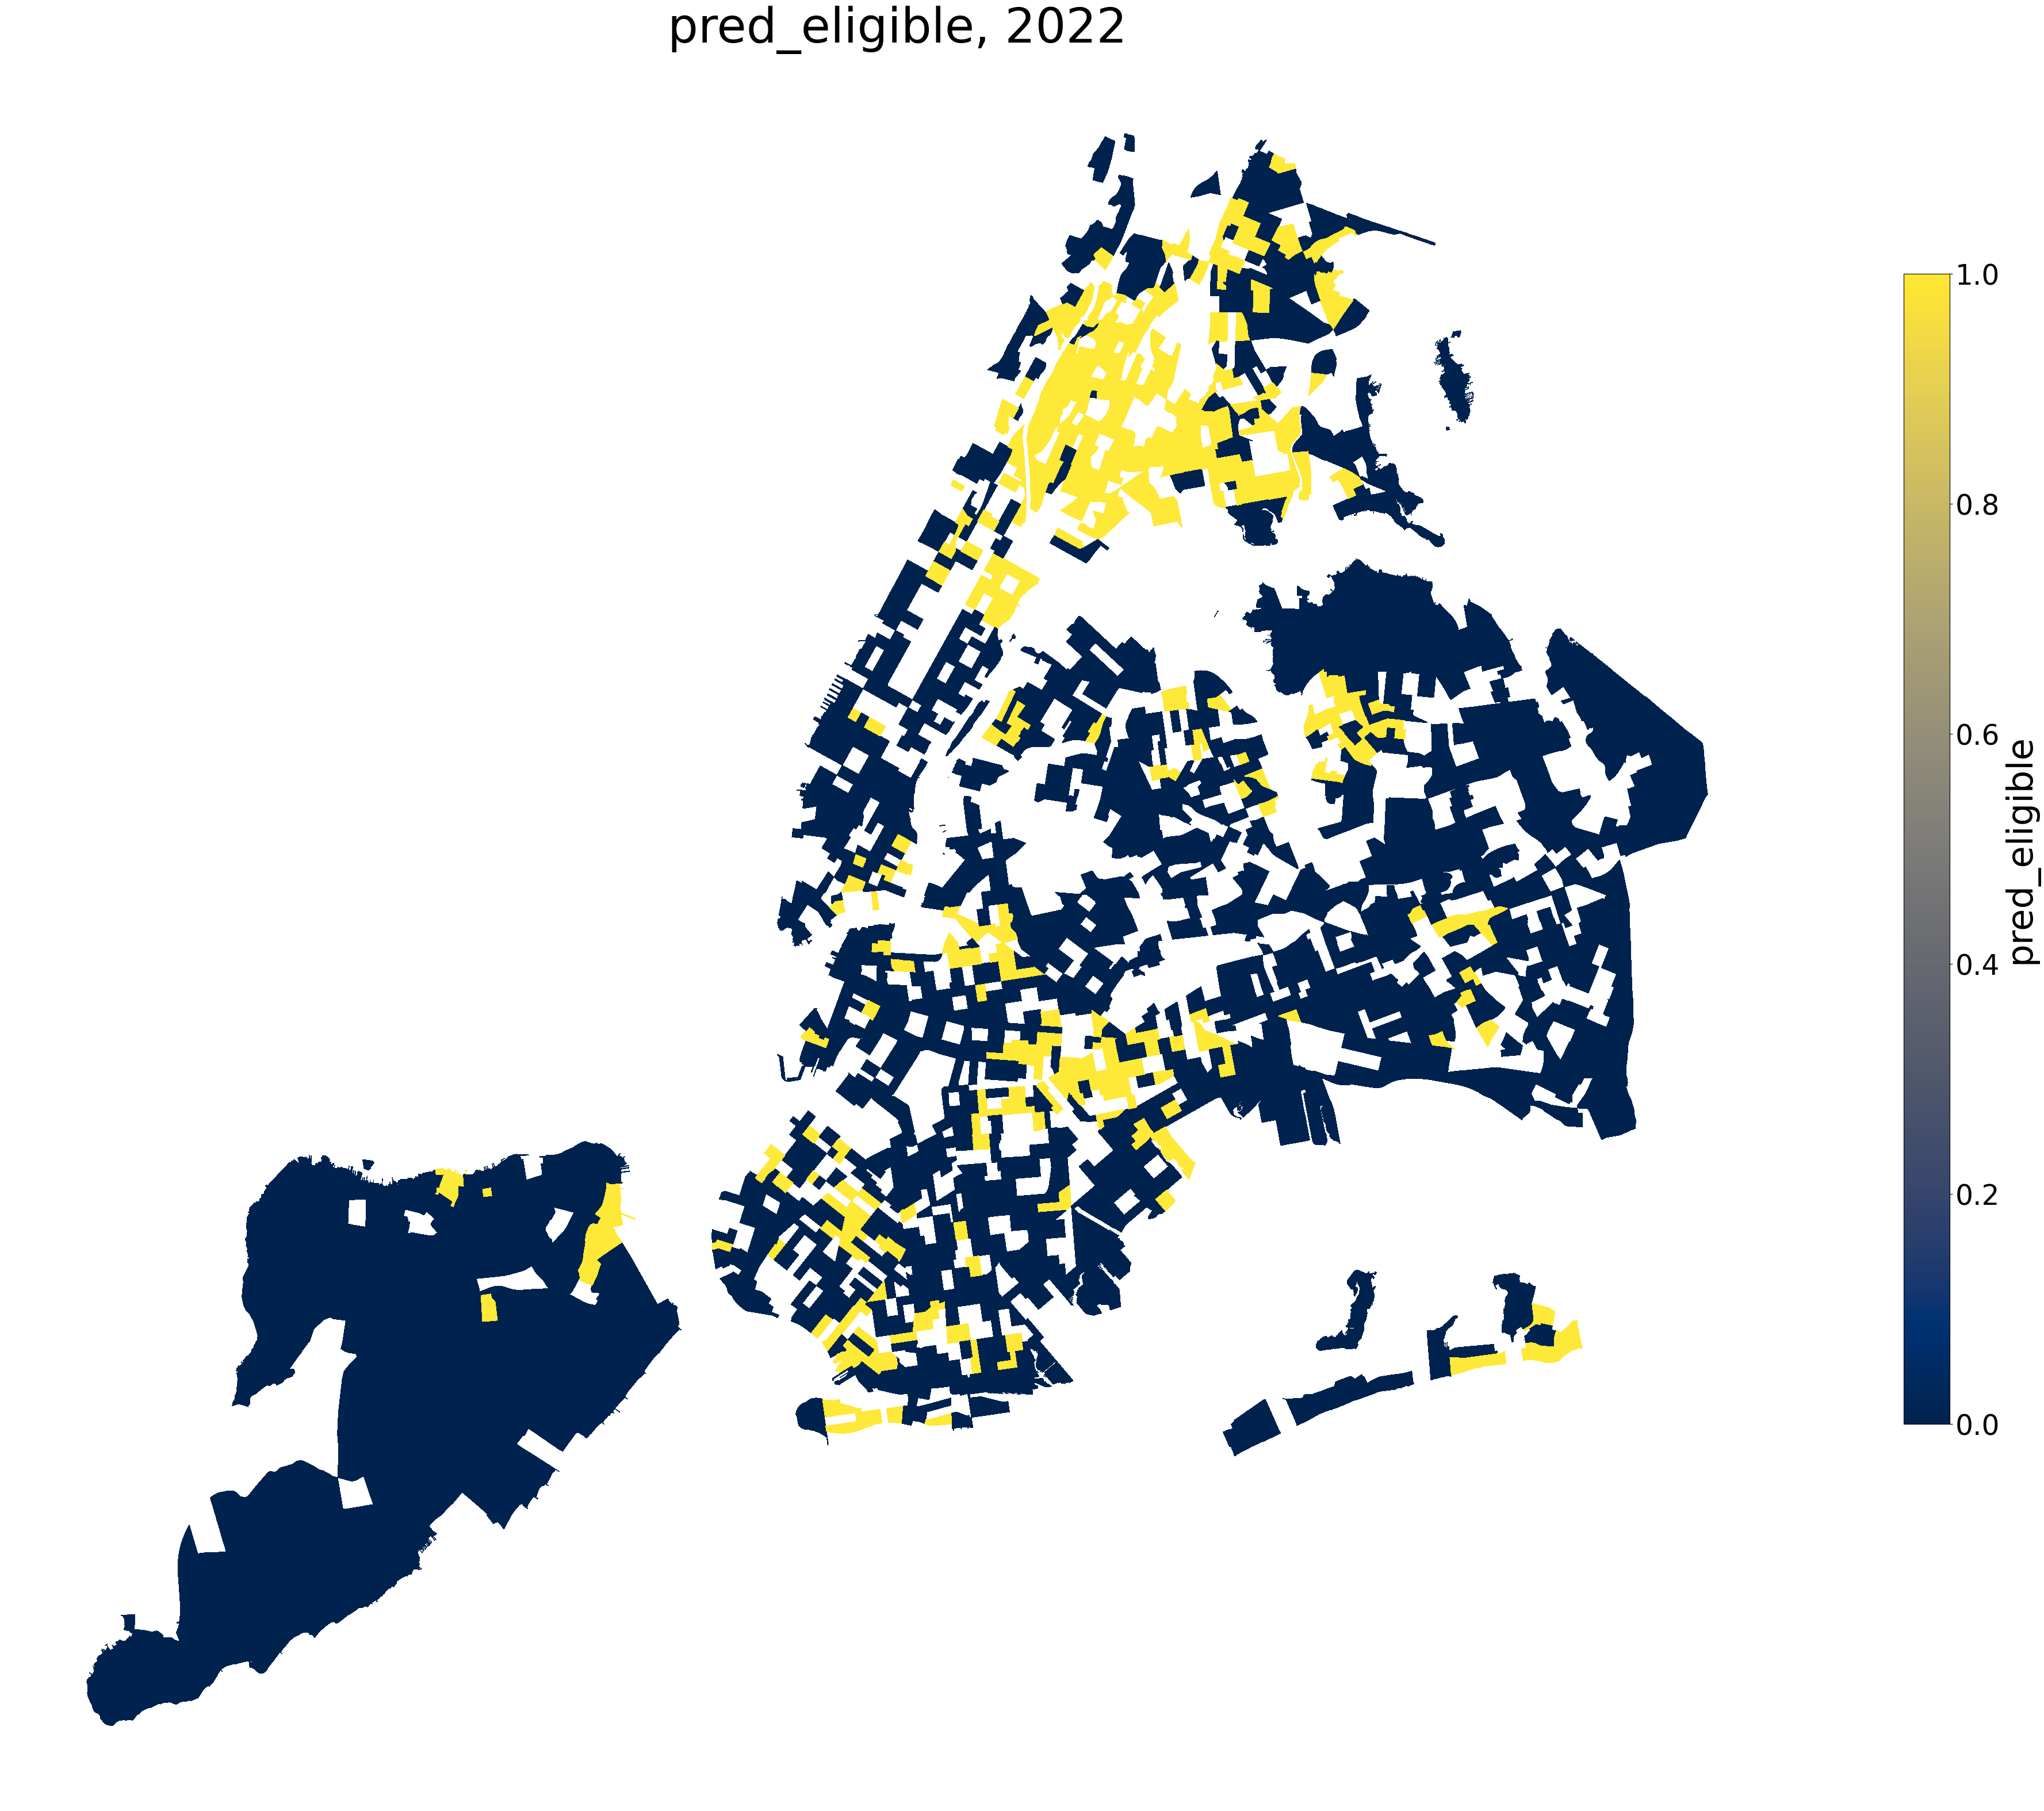

In [29]:
choropleth(df_22, 'pred_eligible', ['2022'], cmap='cividis')